In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.preprocessing import LabelEncoder

In [94]:
df_exam_score = pd.read_csv("/home/hatice/Desktop/DS_UniVR/first_year/programmingAndDB/programming_final_project/Expanded_data_with_more_features.csv")

In [95]:
# better visualization of numbers
pd.options.display.float_format = '{:,.2f}'.format 

# FUNCTIONS

In [96]:
def transform_string_to_numerical(my_df):
    """
    Transform string variables in the DataFrame to numerical representation using LabelEncoder.
    Preserve NaN values as NaN.

    Parameters:
    - my_df: pandas DataFrame containing string variables

    Returns:
    - transformed_df: DataFrame with string variables transformed into numerical representation
    """
    transformed_df = my_df.copy()  # Create a copy of the original DataFrame

    for column in transformed_df.columns:
        if transformed_df[column].dtype == 'object':  # Check if the column contains string variables
            label_encoder = LabelEncoder()

            # Filter out NaN values and fit the LabelEncoder
            label_encoder.fit(transformed_df[column].dropna().unique())

            # Transform the column, preserving NaN values
            transformed_df[column] = transformed_df[column].apply(
                lambda x: label_encoder.transform([x])[0] if pd.notnull(x) else np.nan
            )

    return transformed_df


# DATA EXPLORATION AND DATA WRANGLING

##  Dataset exploration

In [97]:
df_exam_score.shape

(30641, 15)

In [98]:
df_exam_score.T

,0,1,2,3,4,5,6,7,8,9,...,30631,30632,30633,30634,30635,30636,30637,30638,30639,30640
Unnamed: 0,0,1,2,3,4,5,6,7,8,9,...,765,778,783,785,794,816,890,911,934,960
Gender,female,female,female,male,male,female,female,male,male,female,...,male,female,female,male,male,female,male,female,female,male
EthnicGroup,NaN,group C,group B,group A,group C,group B,group B,group B,group D,group B,...,group E,group D,group C,group A,group C,group D,group E,NaN,group D,group B
ParentEduc,bachelor's degree,some college,master's degree,associate's degree,some college,associate's degree,some college,some college,high school,high school,...,some high school,some college,master's degree,associate's degree,some college,high school,high school,high school,associate's degree,some college
LunchType,standard,standard,standard,free/reduced,standard,standard,standard,free/reduced,free/reduced,free/reduced,...,standard,standard,standard,free/reduced,standard,standard,standard,free/reduced,standard,standard
TestPrep,none,NaN,none,none,none,none,completed,none,completed,none,...,none,none,completed,completed,none,none,none,completed,completed,none
ParentMaritalStatus,married,married,single,married,married,married,widowed,married,single,married,...,married,married,married,NaN,married,single,single,married,married,married
PracticeSport,regularly,sometimes,sometimes,never,sometimes,regularly,never,sometimes,sometimes,regularly,...,sometimes,regularly,never,sometimes,regularly,sometimes,regularly,sometimes,regularly,never
IsFirstChild,yes,yes,yes,no,yes,yes,no,yes,no,yes,...,no,no,no,no,no,no,no,no,no,no
NrSiblings,3.00,0.00,4.00,1.00,0.00,1.00,1.00,1.00,3.00,NaN,...,3.00,3.00,2.00,2.00,2.00,2.00,1.00,1.00,3.00,1.00


In [99]:
df_exam_score.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30641 entries, 0 to 30640
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Unnamed: 0           30641 non-null  int64  
 1   Gender               30641 non-null  object 
 2   EthnicGroup          28801 non-null  object 
 3   ParentEduc           28796 non-null  object 
 4   LunchType            30641 non-null  object 
 5   TestPrep             28811 non-null  object 
 6   ParentMaritalStatus  29451 non-null  object 
 7   PracticeSport        30010 non-null  object 
 8   IsFirstChild         29737 non-null  object 
 9   NrSiblings           29069 non-null  float64
 10  TransportMeans       27507 non-null  object 
 11  WklyStudyHours       29686 non-null  object 
 12  MathScore            30641 non-null  int64  
 13  ReadingScore         30641 non-null  int64  
 14  WritingScore         30641 non-null  int64  
dtypes: float64(1), int64(4), object(10)


In [100]:
df_exam_score.describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,"30,641.00",499.56,288.75,0.00,249.00,500.00,750.00,999.00
NrSiblings,"29,069.00",2.15,1.46,0.00,1.00,2.00,3.00,7.00
MathScore,"30,641.00",66.56,15.36,0.00,56.00,67.00,78.00,100.00
ReadingScore,"30,641.00",69.38,14.76,10.00,59.00,70.00,80.00,100.00
WritingScore,"30,641.00",68.42,15.44,4.00,58.00,69.00,79.00,100.00


In [101]:
df_exam_score_copy = df_exam_score.copy()

### Correlation:
I transformed string values into numerical in order to have a new dataframe that I can use to see all correations.
<br> Deleted the first column because it was used  as index but we don't needed as we use pandas dataframe 

In [102]:
df_exam_score_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30641 entries, 0 to 30640
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Unnamed: 0           30641 non-null  int64  
 1   Gender               30641 non-null  object 
 2   EthnicGroup          28801 non-null  object 
 3   ParentEduc           28796 non-null  object 
 4   LunchType            30641 non-null  object 
 5   TestPrep             28811 non-null  object 
 6   ParentMaritalStatus  29451 non-null  object 
 7   PracticeSport        30010 non-null  object 
 8   IsFirstChild         29737 non-null  object 
 9   NrSiblings           29069 non-null  float64
 10  TransportMeans       27507 non-null  object 
 11  WklyStudyHours       29686 non-null  object 
 12  MathScore            30641 non-null  int64  
 13  ReadingScore         30641 non-null  int64  
 14  WritingScore         30641 non-null  int64  
dtypes: float64(1), int64(4), object(10)


In [108]:
df_exam_score_transformed = transform_string_to_numerical(df_exam_score_copy)
del df_exam_score_transformed['Unnamed: 0']

In [109]:
df_exam_score_transformed

,Gender,EthnicGroup,ParentEduc,LunchType,TestPrep,ParentMaritalStatus,PracticeSport,IsFirstChild,NrSiblings,TransportMeans,WklyStudyHours,MathScore,ReadingScore,WritingScore
0,0,NaN,1.00,1,1.00,1.00,1.00,1.00,3.00,1.00,1.00,71,71,74
1,0,2.00,4.00,1,NaN,1.00,2.00,1.00,0.00,NaN,0.00,69,90,88
2,0,1.00,3.00,1,1.00,2.00,2.00,1.00,4.00,1.00,1.00,87,93,91
3,1,0.00,0.00,0,1.00,1.00,0.00,0.00,1.00,NaN,0.00,45,56,42
4,1,2.00,4.00,1,1.00,1.00,2.00,1.00,0.00,1.00,0.00,76,78,75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30636,0,3.00,2.00,1,1.00,2.00,2.00,0.00,2.00,1.00,0.00,59,61,65
30637,1,4.00,2.00,1,1.00,2.00,1.00,0.00,1.00,0.00,0.00,58,53,51
30638,0,NaN,2.00,0,0.00,1.00,2.00,0.00,1.00,0.00,0.00,61,70,67
30639,0,3.00,0.00,1,0.00,1.00,1.00,0.00,3.00,1.00,0.00,82,90,93


In [110]:
df_exam_score_corr = df_exam_score_transformed.corr()

In [111]:
df_exam_score_corr

,Gender,EthnicGroup,ParentEduc,LunchType,TestPrep,ParentMaritalStatus,PracticeSport,IsFirstChild,NrSiblings,TransportMeans,WklyStudyHours,MathScore,ReadingScore,WritingScore
Gender,1.00,0.00,-0.00,-0.00,0.01,0.00,0.00,0.00,-0.00,0.01,0.01,0.16,-0.24,-0.29
EthnicGroup,0.00,1.00,0.00,-0.00,0.00,-0.00,-0.01,0.00,0.00,0.01,0.00,0.22,0.15,0.16
ParentEduc,-0.00,0.00,1.00,0.01,-0.01,-0.00,-0.01,0.00,0.00,-0.00,0.01,-0.11,-0.11,-0.12
LunchType,-0.00,-0.00,0.01,1.00,0.00,-0.01,-0.01,0.00,0.00,0.00,0.00,0.37,0.26,0.27
TestPrep,0.01,0.00,-0.01,0.00,1.00,0.00,-0.01,0.00,0.01,0.01,0.01,-0.14,-0.22,-0.30
ParentMaritalStatus,0.00,-0.00,-0.00,-0.01,0.00,1.00,-0.00,-0.01,-0.00,-0.00,-0.00,-0.01,-0.01,-0.01
PracticeSport,0.00,-0.01,-0.01,-0.01,-0.01,-0.00,1.00,-0.00,-0.00,0.00,-0.00,0.02,0.01,0.01
IsFirstChild,0.00,0.00,0.00,0.00,0.00,-0.01,-0.00,1.00,-0.12,-0.00,-0.00,0.02,0.01,0.01
NrSiblings,-0.00,0.00,0.00,0.00,0.01,-0.00,-0.00,-0.12,1.00,-0.01,0.00,-0.00,-0.00,-0.00
TransportMeans,0.01,0.01,-0.00,0.00,0.01,-0.00,0.00,-0.00,-0.01,1.00,-0.00,0.01,-0.00,-0.00


<AxesSubplot:>

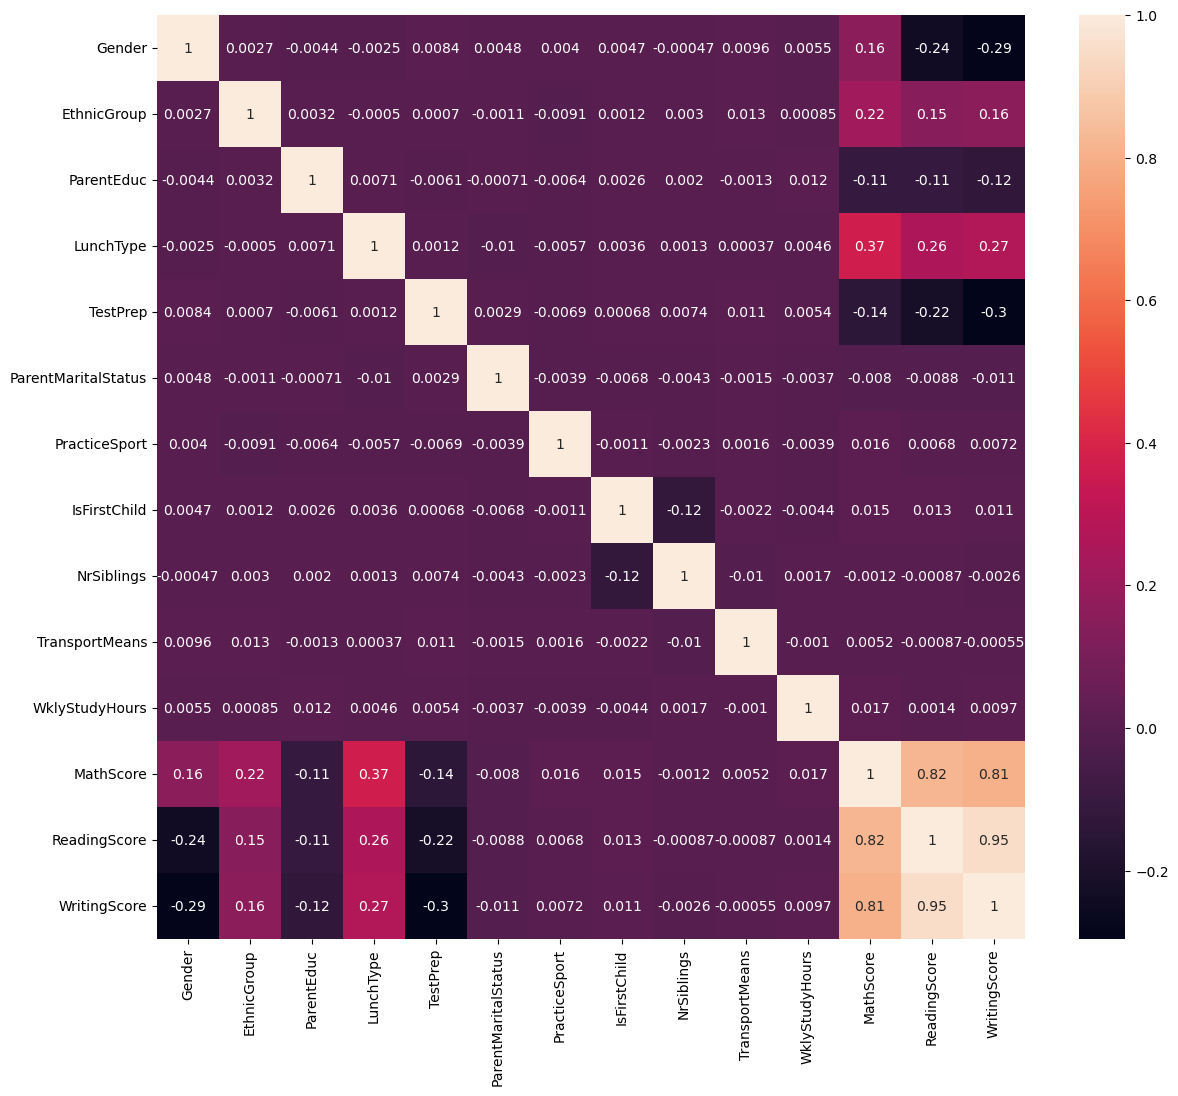

In [120]:
plt.figure(figsize=(14, 12))
sb.heatmap(df_exam_score_corr, annot=True)

## Dataset cleaning 

In [116]:
# add a column called GradePointAvarage and fill it with average of grade point of the student
df_exam_score_transformed["GradePointAvarage"] = (df_exam_score_transformed["MathScore"] + df_exam_score_transformed["ReadingScore"] + df_exam_score_transformed["WritingScore"] ) / 3
df_exam_score_transformed.T

,0,1,2,3,4,5,6,7,8,9,...,30631,30632,30633,30634,30635,30636,30637,30638,30639,30640
Gender,0.00,0.00,0.00,1.00,1.00,0.00,0.00,1.00,1.00,0.00,...,1.00,0.00,0.00,1.00,1.00,0.00,1.00,0.00,0.00,1.00
EthnicGroup,NaN,2.00,1.00,0.00,2.00,1.00,1.00,1.00,3.00,1.00,...,4.00,3.00,2.00,0.00,2.00,3.00,4.00,NaN,3.00,1.00
ParentEduc,1.00,4.00,3.00,0.00,4.00,0.00,4.00,4.00,2.00,2.00,...,5.00,4.00,3.00,0.00,4.00,2.00,2.00,2.00,0.00,4.00
LunchType,1.00,1.00,1.00,0.00,1.00,1.00,1.00,0.00,0.00,0.00,...,1.00,1.00,1.00,0.00,1.00,1.00,1.00,0.00,1.00,1.00
TestPrep,1.00,NaN,1.00,1.00,1.00,1.00,0.00,1.00,0.00,1.00,...,1.00,1.00,0.00,0.00,1.00,1.00,1.00,0.00,0.00,1.00
ParentMaritalStatus,1.00,1.00,2.00,1.00,1.00,1.00,3.00,1.00,2.00,1.00,...,1.00,1.00,1.00,NaN,1.00,2.00,2.00,1.00,1.00,1.00
PracticeSport,1.00,2.00,2.00,0.00,2.00,1.00,0.00,2.00,2.00,1.00,...,2.00,1.00,0.00,2.00,1.00,2.00,1.00,2.00,1.00,0.00
IsFirstChild,1.00,1.00,1.00,0.00,1.00,1.00,0.00,1.00,0.00,1.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
NrSiblings,3.00,0.00,4.00,1.00,0.00,1.00,1.00,1.00,3.00,NaN,...,3.00,3.00,2.00,2.00,2.00,2.00,1.00,1.00,3.00,1.00
TransportMeans,1.00,NaN,1.00,NaN,1.00,1.00,0.00,0.00,0.00,0.00,...,1.00,0.00,1.00,1.00,1.00,1.00,0.00,0.00,1.00,1.00


In [121]:
df_exam_score_corr = df_exam_score_transformed.corr()

<AxesSubplot:>

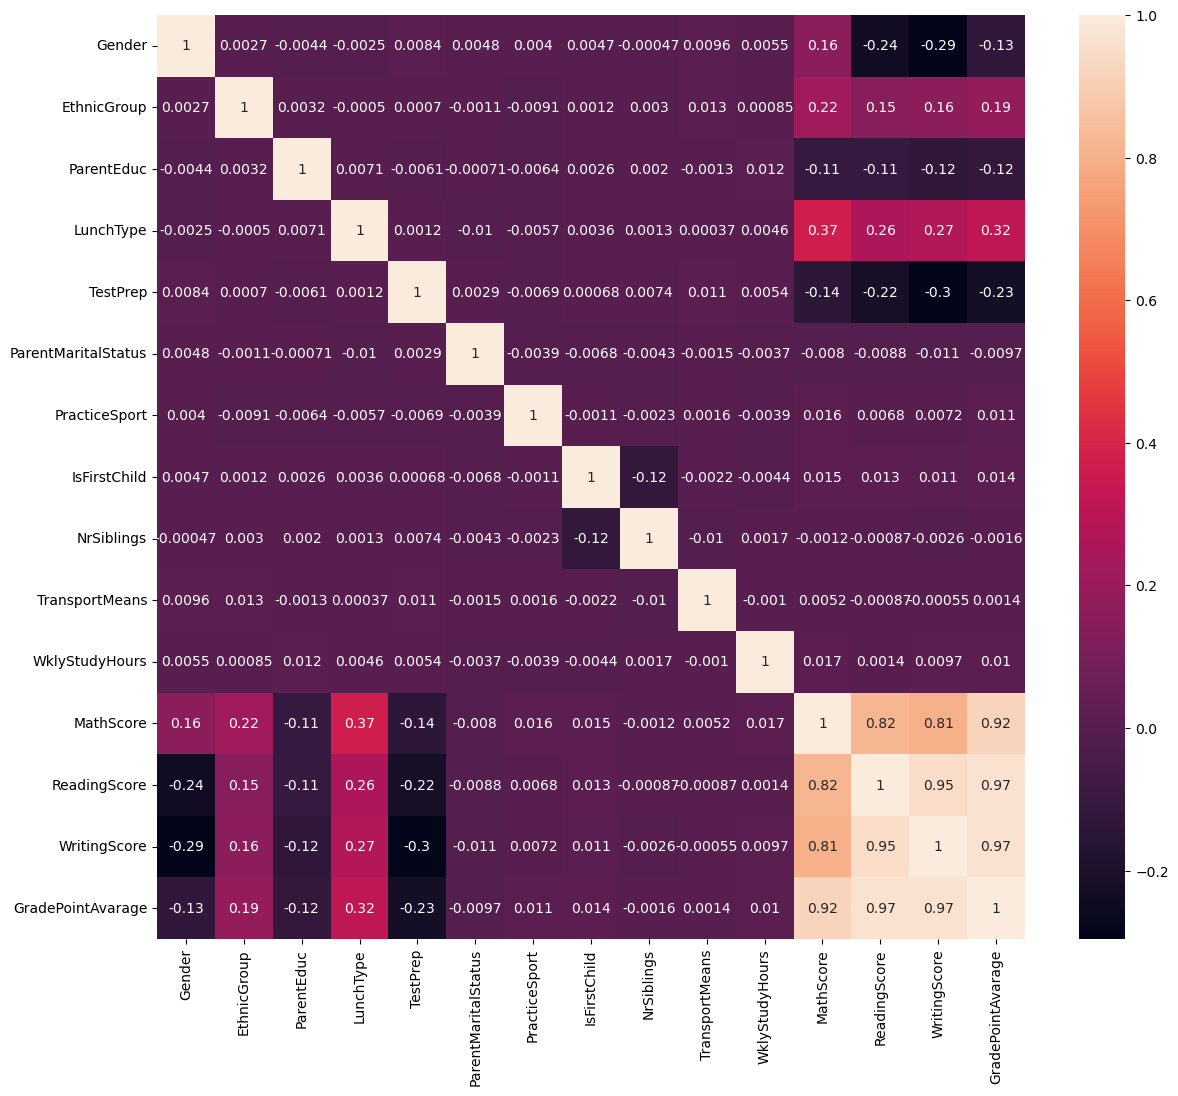

In [122]:
plt.figure(figsize=(14, 12))
sb.heatmap(df_exam_score_corr, annot=True)

In [117]:
MathScoreAvarage = df_exam_score_transformed["MathScore"].mean()
ReadingScoreAvarage = df_exam_score_transformed["ReadingScore"].mean()
WritingScoreAvarage = df_exam_score_transformed["WritingScore"].mean()

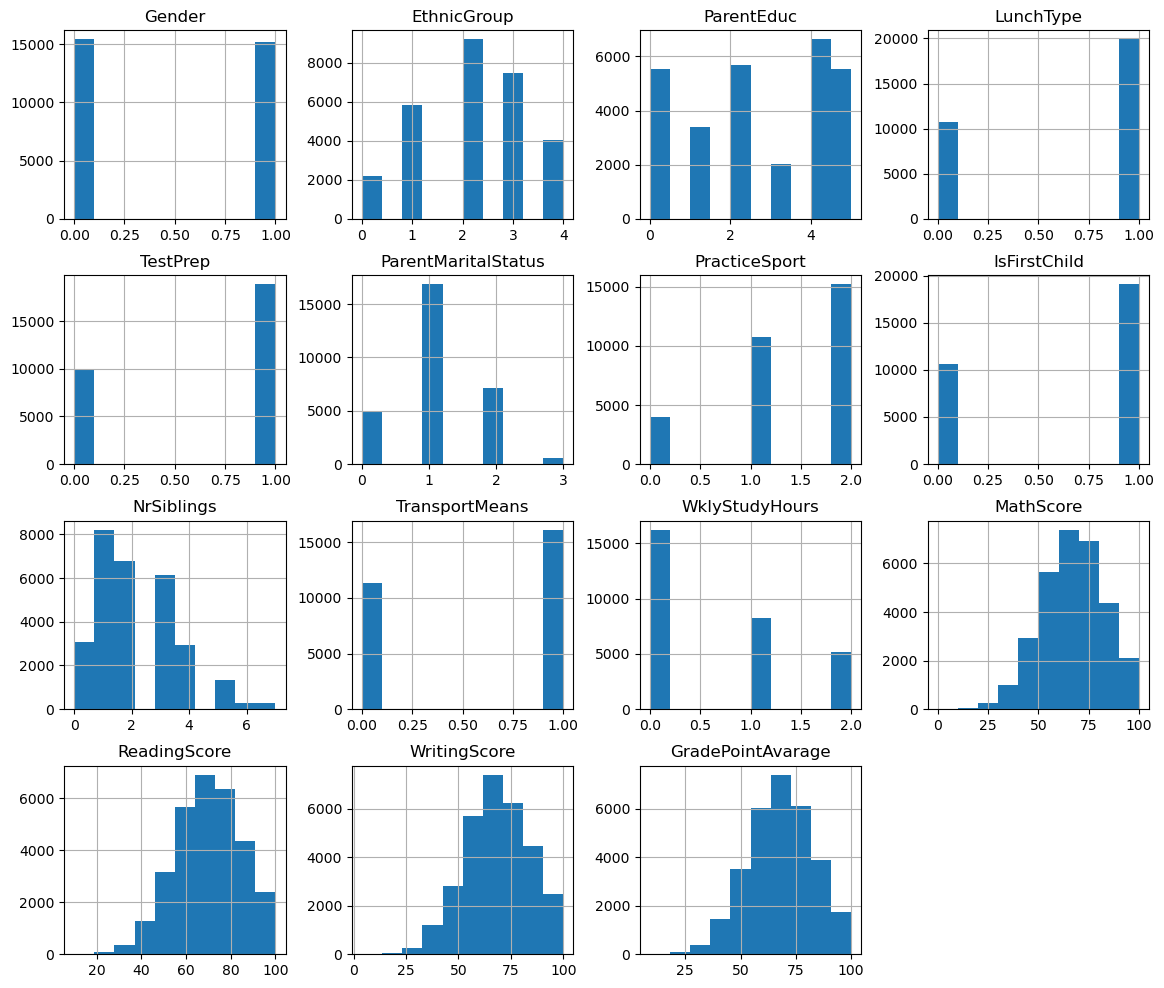

In [129]:
df_exam_score_transformed.hist(figsize=(14, 12), bins = 10)
plt.show()

## Plots

In [14]:
#bar_plot = [["math", "reading", "writing"], [MathScoreAvarage, ReadingScoreAvarage, WritingScoreAvarage]]

In [15]:
#plt.figure(figsize=(10, 6))
#bars = plt.bar(bar_plot[0], bar_plot[1])
#plt.xlabel = ('Subjects')
#plt.ylabel(" Avarage Scores")
#plt.show()

In [16]:
#df_exam_score.plot(title="DataFrame plot")

# MODEL